# PART 2 - CAPP 30254 DIAGNOSTIC

In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

I will focused on 'Vacant and Abandoned Buildings' and 'Sanitation'.

In order to limit the number of requests, I will be focusing on the last 3 months of 2016.

In particular, I aim to assess the income distribution per zip code for these two databases.

In [2]:
buildings = pd.read_csv("311_Service_Requests_-_Vacant_and_Abandoned_Buildings_Reported-3_months.csv")

In [3]:
buildings.head(1)

,SERVICE REQUEST TYPE,SERVICE REQUEST NUMBER,DATE SERVICE REQUEST WAS RECEIVED,"LOCATION OF BUILDING ON THE LOT (IF GARAGE, CHANGE TYPE CODE TO BGD).",IS THE BUILDING DANGEROUS OR HAZARDOUS?,IS BUILDING OPEN OR BOARDED?,"IF THE BUILDING IS OPEN, WHERE IS THE ENTRY POINT?",IS THE BUILDING CURRENTLY VACANT OR OCCUPIED?,IS THE BUILDING VACANT DUE TO FIRE?,"ANY PEOPLE USING PROPERTY? (HOMELESS, CHILDEN, GANGS)",...,ADDRESS STREET SUFFIX,ZIP CODE,X COORDINATE,Y COORDINATE,Ward,Police District,Community Area,LATITUDE,LONGITUDE,Location
0,Vacant/Abandoned Building,16-06902848,10/01/2016,Rear,NaN,Open,BACK DOOR,Vacant,False,True,...,AVE,60628.0,1.177385e+06,1.837852e+06,9,5,49,41.710392,-87.62599,"(41.710391684078424, -87.62598966616069)"


In [4]:
buildings.shape

(702, 23)

In [5]:
sum(pd.isnull(buildings["LATITUDE"]))

0

In [6]:
sum(pd.isnull(buildings["LONGITUDE"]))

0

There are no null values for Lat and Lon. We will proceed with out analysis.

Upon querying the api - it seems that information is stored in 'blocks' called Federal Information Processing Series (FIPS).

I will now create a function that obtain the fips blocks and stores them into a dataframe.

In [7]:
def scrape_fip_blocks(df):
    blocks = []
    for index, row in df.iterrows():
        lat = row['LATITUDE']
        lon = row['LONGITUDE']
        html ="http://data.fcc.gov/api/block/find?format=json&latitude={lat}&longitude={lon}&showall=false".format(lat=lat, lon= lon)
        r = requests.get(html)
        json = r.json()
        fips_info = json["Block"]["FIPS"]
        blocks.append(fips_info)
        
    fips_df = pd.DataFrame(blocks)
    building_fips_df = pd.concat([df,fips_df], axis=1)
    building_fips_df = building_fips_df.rename(columns={0 : "FIPS_BLOCK_NUMBER"})
    
    return building_fips_df

In [8]:
building_fips_df = scrape_fip_blocks(buildings)

In [9]:
building_fips_df.to_pickle("building_fips.pkl")

In [10]:
building_fips_df = pd.read_pickle("building_fips.pkl")

The above two lines of code refer to pickling. This is how we store large dataframes without haveing to reload/re-run onld commands everytime we need to consult the dataframes. This is especially useful for large dataframes

In [11]:
building_fips_df.head(1)

,SERVICE REQUEST TYPE,SERVICE REQUEST NUMBER,DATE SERVICE REQUEST WAS RECEIVED,"LOCATION OF BUILDING ON THE LOT (IF GARAGE, CHANGE TYPE CODE TO BGD).",IS THE BUILDING DANGEROUS OR HAZARDOUS?,IS BUILDING OPEN OR BOARDED?,"IF THE BUILDING IS OPEN, WHERE IS THE ENTRY POINT?",IS THE BUILDING CURRENTLY VACANT OR OCCUPIED?,IS THE BUILDING VACANT DUE TO FIRE?,"ANY PEOPLE USING PROPERTY? (HOMELESS, CHILDEN, GANGS)",...,ZIP CODE,X COORDINATE,Y COORDINATE,Ward,Police District,Community Area,LATITUDE,LONGITUDE,Location,FIPS_BLOCK_NUMBER
0,Vacant/Abandoned Building,16-06902848,10/01/2016,Rear,NaN,Open,BACK DOOR,Vacant,False,True,...,60628.0,1.177385e+06,1.837852e+06,9,5,49,41.710392,-87.62599,"(41.710391684078424, -87.62598966616069)",170314907002004


In [12]:
def scrape_income(df):
    """
    Function that retrieves the INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)!!Total households based on a FIPS
    """
    avg_income_list=[]
    
    for index, row in df.iterrows():
        state = row["FIPS_BLOCK_NUMBER"][0:2]
        county = row["FIPS_BLOCK_NUMBER"][2:5]
        tract = row["FIPS_BLOCK_NUMBER"][5:11]
        html ="http://api.census.gov/data/2015/acs5/profile?get=DP03_0051E,NAME&for=tract:{tract}&in=state:{state}+county:{county}&key=5114f013c5c3a46e13d51564a7d6411436e2b063".format(state=state, county= county, tract=tract)
        r = requests.get(html)
        if r.status_code!=204: #204 corresponds to no content.
            json = r.json()
            income_amount= json[1][0]

            avg_income_list.append(income_amount)
    
    income = pd.DataFrame(avg_income_list)
    buildings_income_df = pd.concat([df,income], axis=1)
    buildings_income_df = buildings_income_df.rename(columns={0 : "Average Income"})
    
    return buildings_income_df

In [13]:
buildings_income_df = scrape_income(building_fips_df)

In [14]:
buildings_income_df.to_pickle("buildings_income.pkl")

In [15]:
buildings_income_df = pd.read_pickle("buildings_income.pkl")

In [16]:
buildings_income_df.head(1)

,SERVICE REQUEST TYPE,SERVICE REQUEST NUMBER,DATE SERVICE REQUEST WAS RECEIVED,"LOCATION OF BUILDING ON THE LOT (IF GARAGE, CHANGE TYPE CODE TO BGD).",IS THE BUILDING DANGEROUS OR HAZARDOUS?,IS BUILDING OPEN OR BOARDED?,"IF THE BUILDING IS OPEN, WHERE IS THE ENTRY POINT?",IS THE BUILDING CURRENTLY VACANT OR OCCUPIED?,IS THE BUILDING VACANT DUE TO FIRE?,"ANY PEOPLE USING PROPERTY? (HOMELESS, CHILDEN, GANGS)",...,X COORDINATE,Y COORDINATE,Ward,Police District,Community Area,LATITUDE,LONGITUDE,Location,FIPS_BLOCK_NUMBER,Average Income
0,Vacant/Abandoned Building,16-06902848,10/01/2016,Rear,NaN,Open,BACK DOOR,Vacant,False,True,...,1.177385e+06,1.837852e+06,9,5,49,41.710392,-87.62599,"(41.710391684078424, -87.62598966616069)",170314907002004,891


In [17]:
type(buildings_income_df["Average Income"][0])

str

From the above we can see that out entries for average income are strings. We need to change these to integers so that we can create a nice graph!

In [18]:
temp = list(buildings_income_df["Average Income"])

In [19]:
int_temp = [int(x) for x in temp]

In [20]:
type(int_temp[0]) #Success.

int

Now we need to add this back onto our dataframe!

In [21]:
buildings_income_df.drop(["Average Income"], axis=1, inplace=True)

In [22]:
pd_int_temp = pd.DataFrame({"Average Income": int_temp})

In [23]:
buildings_income_df = pd.concat([buildings_income_df, pd_int_temp], axis=1)

Now I will plot the distrubiton of average income grouped by ZipCode. Our dataframe displayes the average income per house, we will classify these houses into ZipCodes and then obtain the average income of those groups. This is what will be plotted.

In [25]:
income_dist = pd.DataFrame(buildings_income_df['Average Income'].groupby(buildings_income_df['ZIP CODE']).describe().unstack()['mean'].sort_values(ascending=True,inplace=False))

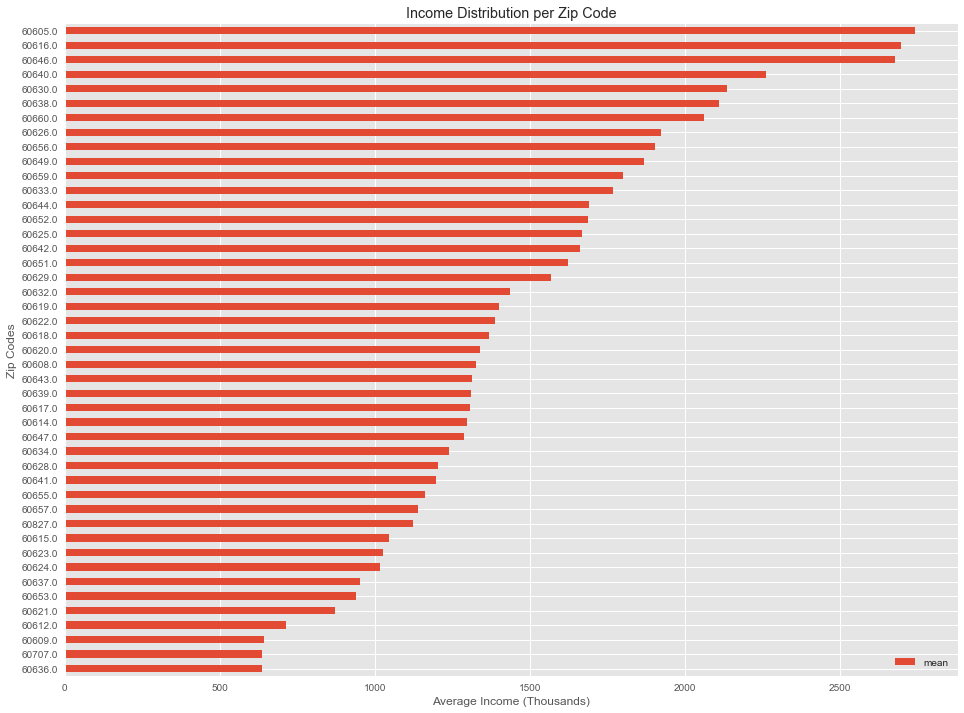

In [26]:
income_dist.plot(kind="barh",figsize=(16, 12))
plt.title("Income Distribution per Zip Code")
plt.xlabel("Average Income (Thousands)")
plt.ylabel("Zip Codes")
plt.show()

I would repeat the same analysis for sanitation, however, after restricting it to the last 3 months, I was faced with over 5000 records.

As for other factors, I had difficulty obtaining information with regards to family size, race etc. I need more time to wrangle with the api.